In [2]:
import math
import functools
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import qutip as qt
import time

In [3]:
# This dictionary maps string keys ('x', 'y', 'z', 'p', 'm', 'i') to functions that generate spin operators for a given dimension dim.
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
# Initializes ops as a list of identity matrices for each dimension in dims. Iterates over specs to replace the identity matrix at the specified index with the corresponding spin operator. Returns the tensor product of the operators in ops using qt.tensor.
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
# Constructs a Hamiltonian for a single spin system with interactions along the x, y, and z axes.
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    # Creates a list of spin operators weighted by the corresponding parameters in parvec (ignores zero parameters). Uses functools.reduce to sum these weighted spin operators.
    return functools.reduce(lambda a, b: a + b, 
               [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0])
# Constructs a Hamiltonian for the interaction between two spin systems with interaction terms along all combinations of x, y, and z axes.
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    ops = []
    # Iterates over all combinations of the x, y, and z axes for the two spins. For each non-zero element in parmat, adds the corresponding spin-spin interaction term to the empty list ops.
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                ops.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    return functools.reduce(lambda a, b: a + b, ops) # Uses functools.reduce to sum these interaction terms.

In [4]:
g = 2.00231930436256 #electron g-factor
beta = 9.274009994e-24 #bohr magneton
hbar = 6.62607015e-34/(2*np.pi) #hbar

N5_C =  2*np.pi* np.array([[-0.36082693, -0.0702137 , -1.41518116],
      [-0.0702137 , -0.60153649,  0.32312139],
      [-1.41518116,  0.32312139, 50.80213093]]) # in MHz
	  
N1_C = 2*np.pi*np.array([[  2.13814981,   3.19255832,  -2.48895215],
      [  3.19255832,  15.45032887, -12.44778343],
      [ -2.48895215, -12.44778343,  12.49532827]]) # in MHz

N5_D =  2*np.pi*np.array([[-2.94412424e-01, -5.68059200e-02, -1.02860888e+00],
      [-5.68059200e-02, -5.40578469e-01, -2.67686240e-02],
      [-1.02860888e+00, -2.67686240e-02,  5.05815320e+01]]) # in MHz
	  
N1_D = 2*np.pi* np.array([[ 0.98491908,  3.28010265, -0.53784491],
      [ 3.28010265, 25.88547678, -1.6335986 ],
      [-0.53784491, -1.6335986 ,  1.41368001]]) # in MHz


ErC_Dee =  np.array([[ 26.47042689, -55.90357828,  50.1679204 ],
                            [-55.90357828, -20.86385225,  76.13493805],
                             [ 50.1679204,  76.13493805,  -5.60657464]]) # in Mrad/s



ErD_Dee = np.array([[ 11.08087889, -34.6687169,   12.14623706],
                            [-34.6687169,  -33.09039672,  22.36229081],
                            [ 12.14623706,  22.36229081,  22.00951783]]) #  in Mrad/s



In [5]:
b0 = 1.4 * 2*math.pi # Zeeman field strength in radians per microsecond

kr = 1. # Rate constant 1/us
tmax = 12. / kr # Maximum time us
tlist = np.linspace(0, tmax, math.ceil(1000*tmax)) # Time points for simulation
B0 = b0 * np.array([1,0,0]) # Magnetic field vector along x-axis

dims = [2, 2, 3, 3, 3] # Dimensions of the system components (2 qubits, 1 spin-1 nucleus)
dim = np.prod(dims) # Total dimension of the composite system
Hzee = mkH1(dims, 0, B0) + mkH1(dims, 1, B0) # Zeeman Hamiltonian for two spins
Hhfc_C = mkH12(dims, 0, 2, N5_C) + mkH12(dims, 1, 3, N1_C)
Hhfc_D = mkH12(dims, 0, 2, N5_D) + mkH12(dims, 1, 4, N1_D)
Hdee_C = mkH12(dims, 0, 1, ErC_Dee)
Hdee_D = mkH12(dims, 0, 1, ErD_Dee)
H0_C = Hzee + Hhfc_C + Hdee_C # Total Hamiltonian
H0_D = Hzee + Hhfc_D + Hdee_D

Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3)) # Singlet projection operator

rho0_C = (Ps / Ps.tr()).full().flatten()# Initial density matrix, normalized projection operator for the singlet state.
rho0_D = np.zeros_like(rho0_C)
H_C = H0_C.data # H: Dense matrix representation of the Hamiltonian H0.
H_D = H0_D.data
Ps = Ps.data

# Combine the initial states into one vector
initial_state = np.concatenate((rho0_C, rho0_D)).flatten()

In [6]:
from scipy.integrate import ode

In [7]:
def mesolve(t, combined_rho, P_s, HA, HB, dimA, dimB):
    # Reshape rho back to a matrix
    lenA = dimA * dimA
    lenB = dimB * dimB
    rhoA = combined_rho[:lenA].reshape((dimA, dimA))
    rhoB = combined_rho[lenB:].reshape((dimB, dimB))
    
    # Compute the derivative of rho
    drhoA_dt = -1j * (HA @ rhoA - rhoA @ HA) - (P_s @ rhoA + rhoA @ P_s)/2 - 2*rhoA + rhoB
    drhoB_dt = -1j * (HB @ rhoB - rhoB @ HB) - (P_s @ rhoB + rhoB @ P_s)/2 - 2*rhoB + rhoA
    
    # Flatten the derivative to a vector
    return np.concatenate((drhoA_dt.flatten(), drhoB_dt.flatten()))

In [8]:
# Create the solver instance
solver = ode(mesolve).set_integrator('zvode', atol=1e-12, rtol=1e-10, method='adams', order=12)
solver.set_initial_value(initial_state, 0).set_f_params( Ps, H_C, H_D, dim, dim)

t = [(0.,1.,0.)]
dt = 0.001

start = time.time()
while solver.successful() and solver.t < tmax:
    rho = solver.integrate(solver.t + dt)
    rho_c = rho[:dim**2].reshape((dim, dim))
    rho_d = rho[dim**2:].reshape((dim, dim))
    t.append((solver.t, np.trace(Ps @ rho_c),np.trace(Ps @ rho_d)))
stop = time.time()

print("{} sec".format(stop - start))
 
tlist = np.array([x for x,y,z in t])
ps_c = np.array([np.real(y) for x,y,z in t])
ps_d= np.array([np.real(z) for x,y,z in t])
ps = np.concatenate((ps_c, ps_d))
yr_c = kr * sci.integrate.simps(ps_c * np.exp(-kr*tlist), tlist)
yr_d = kr * sci.integrate.simps(ps_d * np.exp(-kr*tlist), tlist)
yr_c
yr_d

159.89000415802002 sec


0.029324819570462797

0.13046196935283025 0.029324819570462797


Text(0.5, 1.0, 'Evolution of singlet probability over time')

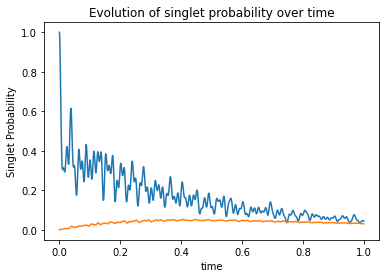

In [10]:
print(yr_c, yr_d)
plt.plot(tlist[:1000], ps_c[:1000])
plt.plot(tlist[:1000], ps_d[:1000])
plt.xlabel('time')
plt.ylabel('Singlet Probability')
plt.title('Evolution of singlet probability over time')

